1. Cleaning:
    + Heatmap origin scale, Gauss sigma = 5
2. Augmentation:
    + resize
    + rotation
    + tf.image.random_contrast
    + tf.image.random_brightness
    + tf.random_normal(shape=tf.shape(x), mean=0.0, stddev=1, dtype=tf.float32)
    + drop block
3. Generator:
    + Multiple input/output
4. Model
    + Inference time estimated at the outset
    + Pretrained hyper column
    + Separable HRNet
    + residual batch norm
    + *dilated conv
    + *attention layer
    + *(costdown) separable conv = depthwise 3*3 combine + 1*1 pointwise reduct
    + *SE-Net: squeeze (global-avg-pooling) + excitation (FCN) + depthwise matmul
5. Loss
    + Customized joint weighted loss for imbalance training
    + *Global loss and refinement loss
6. Post-processing
7. Threshold determined by printing all the data

+ Both Model and Loss use multi-scaled fusion in prevelant models
+ Ideal accuracy >= 1-1/train_val_data_number
+ Remember training/val/testing(unlabled) dataset has no intersection

In [4]:
import os; os.environ["CUDA_VISIBLE_DEVICES"]="3"
import re, math, random, datetime, time, pickle
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import imgaug.augmenters as iaa
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Lambda, concatenate, Conv2D, UpSampling2D, Reshape, Add, BatchNormalization, Activation
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

abspath = "/home/bobhjchao/keypoint/hrnet/input_20211223"
filterLS = lambda keyword,path: list(filter(lambda s: keyword in s, os.listdir(f"{abspath}/{path}")))

print( len(filterLS(".jpg","data")), len(filterLS(".xml","data")) )
classNumber = [ len(filterLS(f"type{i}","data"))//2 for i in range(4) ]
classRatio = [1.0, 1.5, 2.0, 2.0]
print(classNumber, classRatio)

572 572
[345, 111, 62, 54] [1.0, 1.5, 2.0, 2.0]


In [2]:
# data domain
S = set()
for imgName in filterLS(".jpg","data"):
    findList = re.findall("type[0-9]_([0-9]{8,8})",imgName)
    if findList:
        S.add( findList[0] )
print( sorted(list(S)) )

['20201110', '20210906', '20210907', '20210913', '20210914', '20211001', '20211006', '20211007', '20211023', '20211101', '20211107', '20211109', '20211110', '20211112', '20211113', '20211114', '20211115', '20211116', '20211118', '20211119', '20211120', '20211122', '20211123', '20211124', '20211125', '20211126', '20211127', '20211129', '20211202', '20211203', '20211205', '20211206', '20211209', '20211215', '20211216', '20211217', '20211218', '20211221']


In [3]:
sigma = 5
def gauss(k, channel, _):
    row, col = k%(224*224)//224, k%(224*224)%224
    return math.exp( -1/(2*sigma**2)*( (col-keypoint[channel][0])**2+(row-keypoint[channel][1])**2 ) )*255

os.system(f"mkdir {abspath}/heatmap0 {abspath}/heatmap1 {abspath}/heatmap2")
imgPathList=list(map( lambda s:f"{abspath}/data/{s}",filterLS(".jpg","data") ))
for i,imgPath in enumerate(imgPathList):
    print(f"\r{i+1}/{len(imgPathList)}", end=''); continue
    rawImg = cv2.imread(imgPath)
    img = cv2.resize(rawImg, (224,224))
    with open(imgPath.replace('.jpg','.xml'), "r") as f:
        txt = f.read()
        up_xmin, mi_xmin, do_xmin = re.findall("<xmin>([0-9]*)</xmin>", txt)
        up_xmax, mi_xmax, do_xmax = re.findall("<xmax>([0-9]*)</xmax>", txt)
        up_ymin, mi_ymin, do_ymin = re.findall("<ymin>([0-9]*)</ymin>", txt)
        up_ymax, mi_ymax, do_ymax = re.findall("<ymax>([0-9]*)</ymax>", txt)
    upx = (int(up_xmin)+int(up_xmax))/2 /rawImg.shape[1] * 224
    mix = (int(mi_xmin)+int(mi_xmax))/2 /rawImg.shape[1] * 224
    dox = (int(do_xmin)+int(do_xmax))/2 /rawImg.shape[1] * 224
    upy = (int(up_ymin)+int(up_ymax))/2 /rawImg.shape[0] * 224
    miy = (int(mi_ymin)+int(mi_ymax))/2 /rawImg.shape[0] * 224
    doy = (int(do_ymin)+int(do_ymax))/2 /rawImg.shape[0] * 224
    keypoint = [(upx,upy), (mix,miy), (dox,doy)]
    
    for channel in range(3):
        heatmap1D = np.zeros(224*224*1)
        heatmap1D = np.vectorize(gauss)(range(224*224*1), [channel]*(224*224*1), heatmap1D )
        heatmap = heatmap1D[:224*224].reshape(224,224,1)                   
        cv2.imwrite(imgPath.replace('data',f'heatmap{channel}'), heatmap)

print(" ", [len(os.listdir(f"{abspath}/{folder}")) for folder in ["data","heatmap0","heatmap1","heatmap2"] ])

572/572  [1145, 573, 573, 573]


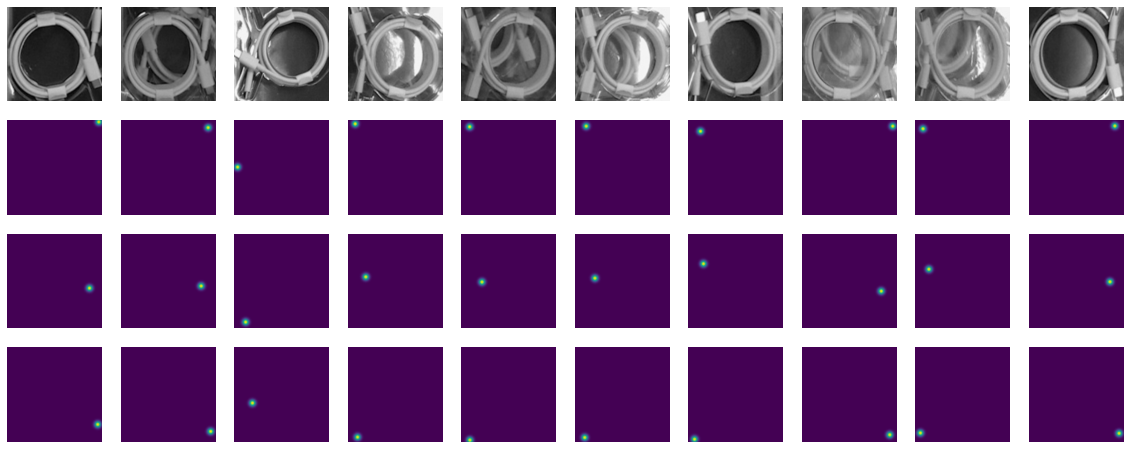

In [4]:
random.shuffle(imgPathList)
plt.figure(figsize=(20,2*4))
for i in range(10):
    plt.subplot(4,10,i+1)
    plt.imshow( cv2.imread(imgPathList[i]) )
    plt.axis('off')
    plt.subplot(4,10,10+i+1)
    plt.imshow( cv2.imread(imgPathList[i].replace("data","heatmap0"),cv2.IMREAD_GRAYSCALE) )
    plt.axis('off')
    plt.subplot(4,10,20+i+1)
    plt.imshow( cv2.imread(imgPathList[i].replace("data","heatmap1"),cv2.IMREAD_GRAYSCALE) )
    plt.axis('off')
    plt.subplot(4,10,30+i+1)
    plt.imshow( cv2.imread(imgPathList[i].replace("data","heatmap2"),cv2.IMREAD_GRAYSCALE) )
    plt.axis('off')
plt.show()

In [15]:
class DataAug:
    def __init__(self, image, rd1, rd2, process): # 255-uint8, float, float, str
        self.rd1, self.rd2 = rd1, rd2 # for resizeRotateFlip
        if process=="raw":
            image = self.contrast(image)
            image = self.brightness(image)
            image = self.noise(image)
            image = self.block(image)
            image = self.resizeRotateFlip(image)
        elif process=="heatmap":
            image = self.resizeRotateFlip(image)
        self.img = image
    
    def resizeRotateFlip(self, image): # 255-uint8, float, float
        op1 = (self.rd1>=0.7) + (self.rd1>=0.8) + (self.rd1>=0.9) 
        op2 = (self.rd2>=0.7)
        aug = iaa.Sequential([
            iaa.Resize(224, interpolation="linear"),
            iaa.Sometimes( int(op1==1), iaa.Affine(scale=(0.8,0.8))),
            iaa.Sometimes( int(op1==2), iaa.Affine(rotate=-10, scale=(0.7,0.7))),
            iaa.Sometimes( int(op1==3), iaa.Affine(rotate=10, scale=(0.7,0.7))),
            #iaa.Flipud( int(op2) ),
        ])
        return aug.augment_image(image)
    
    def contrast(self, image): # 255-uint8 -> 255-uint8
        return tf.image.random_contrast(image, lower=0.6, upper=1).numpy() # more lower more opaque 
    
    def brightness(self, image): # 255-uint8 -> 255-uint8
        return tf.image.random_brightness(image, max_delta=0.2).numpy() # more larger more dark or bright
    
    def noise(self, image):
        if random.random()>=0.5:
            noiseImg = image + np.random.random((image.shape[0],image.shape[1],3))*255*0.3
            return (((noiseImg-noiseImg.min())/(noiseImg.max()-noiseImg.min()))*255).astype(np.uint8) # 255up-float64 -> 255-uint8
        else:
            return image
    
    def block(self, image): # 255-uint8 -> 255-uint8
        s, d, c = 20, 2, 45 # block_size, block_stride, corner distance
        while random.random()>0.3:
            r = random.random()
            if r<0.16:
                by, bx = random.randint(0+s,c-s), random.randint(0+s,c-s)
            elif r<0.33:
                by, bx = random.randint(0+s,c-s), random.randint(224-c+s,224-s)
            elif r<0.5:
                by, bx = random.randint(224-c+s,224-s), random.randint(0+s,c-s)
            elif r<0.66:
                by, bx = random.randint(224-c+s,224-s), random.randint(224-c+s,224-s)
            elif r<0.83:
                by, bx = random.randint(112-5,112+5), random.randint(0+s,c-s)
            else:
                by, bx = random.randint(112-5,112+5), random.randint(224-c+s, 224-s)
            image[by-s:by+s:d, bx-s:bx+s:d, 0] = int(np.random.random()*255)
            image[by-s:by+s:d, bx-s:bx+s:d, 1] = int(np.random.random()*255)
            image[by-s:by+s:d, bx-s:bx+s:d, 2] = int(np.random.random()*255)
        return image

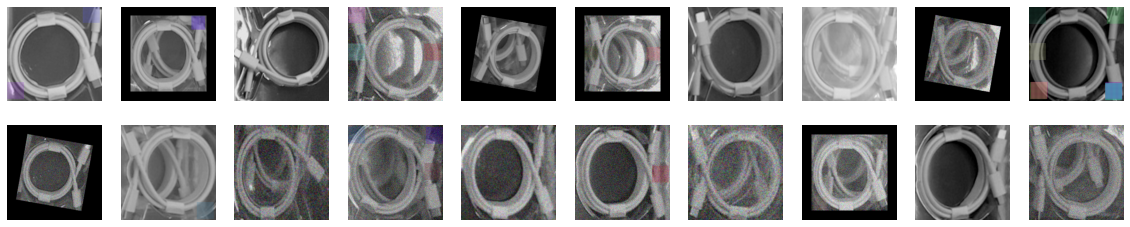

In [6]:
plt.figure(figsize=(20,2*2))
for i in range(20):
    img = cv2.imread(imgPathList[i])
    plt.subplot(2,10,i+1)
    plt.imshow( DataAug(img, random.random(), random.random(), "raw").img )
    plt.axis('off')
plt.show()

In [9]:
class KeyPointsDataset(tf.keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=4, train=True):
        self.image_keys = image_keys # list[str] # all indices
        self.aug = aug               # bool
        self.batch_size = batch_size # int
        self.train = train
        self.on_epoch_end()
    def __len__(self):
        return len(self.image_keys) // self.batch_size
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys)) # np.array([int]) # all indices
        if self.train:
            np.random.shuffle(self.indexes)
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size] # np.array([int]) # indices of a batch
        image_keys_temp = [self.image_keys[k] for k in indexes]                         # np.array([str]) # imgName of a batch
        (images, keypoints) = self.__data_generation(image_keys_temp)
        return (images, keypoints)
    def __data_generation(self, image_keys_temp):
        batch_images  = np.empty( (self.batch_size, 224, 224, 3), dtype="float" )
        batch_classes = np.empty( (self.batch_size,), dtype="float" )
        batch_hm      = np.empty( (self.batch_size, 224, 224, 3), dtype="float" )
        
        for i,imgPath in enumerate(image_keys_temp):
            batch_classes[i] = classRatio[ int(re.findall("type([0-9])", image_keys_temp[i])[0]) ]
            
            rawImg = cv2.imread(imgPath)
            hmImg  = np.zeros((224,224,3))
            hmImg[:,:,0] = cv2.imread(imgPath.replace('data','heatmap0'), cv2.IMREAD_GRAYSCALE)
            hmImg[:,:,1] = cv2.imread(imgPath.replace('data','heatmap1'), cv2.IMREAD_GRAYSCALE)
            hmImg[:,:,2] = cv2.imread(imgPath.replace('data','heatmap2'), cv2.IMREAD_GRAYSCALE)
            
            if self.aug and random.random()>=0.3:
                rd1, rd2 = random.random(), random.random()
                augRawImg = DataAug(rawImg, rd1, rd2, "raw").img
                augHmImg  = DataAug(hmImg, rd1, rd2, "heatmap").img
            else:
                augRawImg = cv2.resize(rawImg, (224,224))
                augHmImg  = cv2.resize(hmImg, (224,224))

            batch_images[i]  = (augRawImg-augRawImg.min())/(augRawImg.max()-augRawImg.min())
            batch_hm[i]      = (augHmImg-augHmImg.min())  /(augHmImg.max()-augHmImg.min())
        
        return ( (batch_images,batch_classes), batch_hm )

In [8]:
random.shuffle(imgPathList)
train_keys, val_keys = imgPathList[:int(0.8*len(imgPathList))], imgPathList[int(0.8*len(imgPathList)):]

train_dataset = KeyPointsDataset(train_keys, aug=True)
validation_dataset = KeyPointsDataset(val_keys, aug=False, train=False)
print(len(train_dataset), len(validation_dataset))
with open("train_dataset.pkl", "wb") as f:
    pickle.dump(train_dataset, f)
with open("validation_dataset.pkl", "wb") as f:
    pickle.dump(validation_dataset, f)

114 28


[1.0, 1.5, 2.0, 2.0]


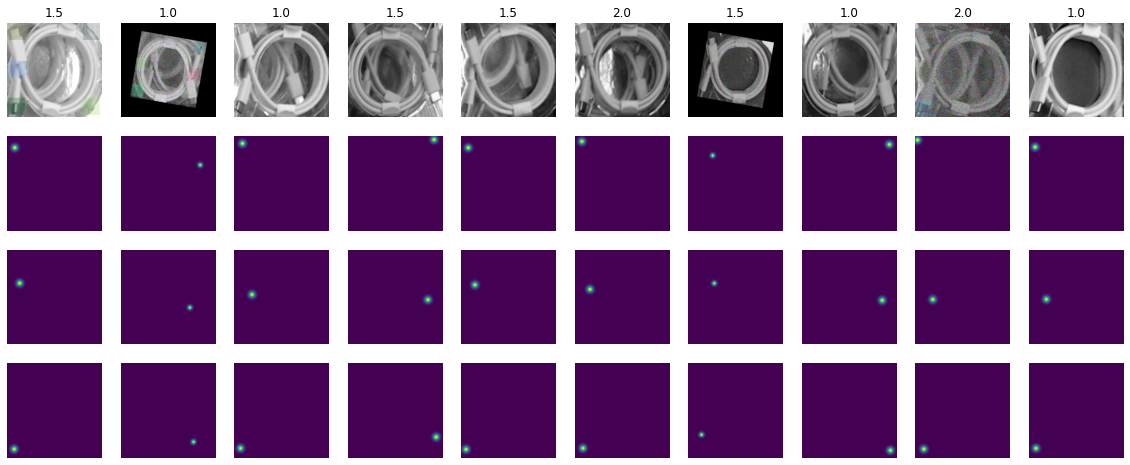

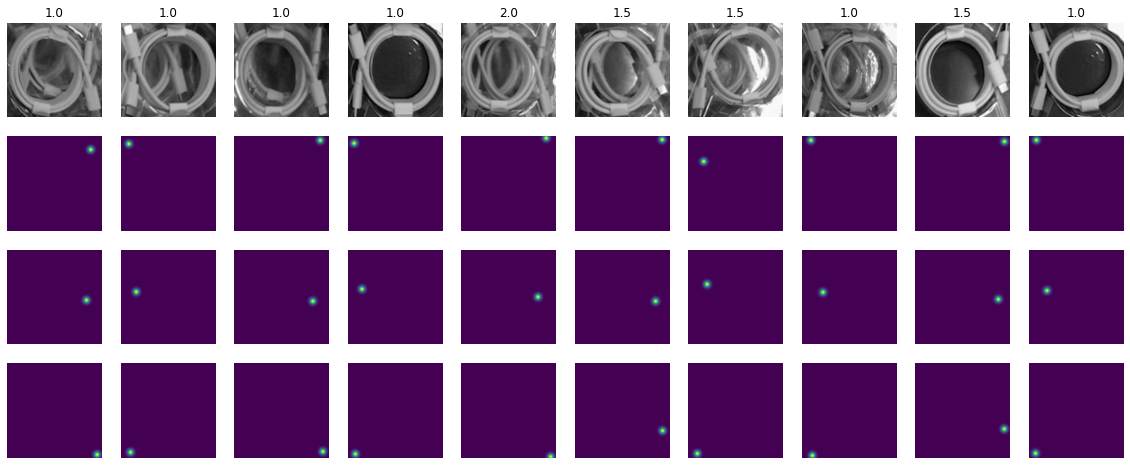

In [9]:
print(classRatio)

example_dataset = KeyPointsDataset(train_keys[:16], aug=True, batch_size=16)
plt.figure(figsize=(20,2*4))
for batch in example_dataset:
    (imgs, classes), hms = batch # (10,224,224,3), (10,), (10,224,224,3)
    for i in range(10):
        plt.subplot(4,10,i+1)
        plt.title( classes[i] )
        plt.imshow( imgs[i] )
        plt.axis('off')
        plt.subplot(4,10,i+11)
        plt.imshow( hms[i,:,:,0]  )
        plt.axis('off')
        plt.subplot(4,10,i+21)
        plt.imshow( hms[i,:,:,1]  )
        plt.axis('off')
        plt.subplot(4,10,i+31)
        plt.imshow( hms[i,:,:,2]  )
        plt.axis('off')
plt.show()

example_dataset = KeyPointsDataset(val_keys[:16], aug=False, batch_size=16)
plt.figure(figsize=(20,2*4))
for batch in example_dataset: 
    (imgs, classes), hms = batch # (10,224,224,3), (10,), (10,224,224,3)
    for i in range(10):
        plt.subplot(4,10,i+1)
        plt.title( classes[i] )
        plt.imshow( imgs[i] )
        plt.axis('off')
        plt.subplot(4,10,i+11)
        plt.imshow( hms[i,:,:,0]  )
        plt.axis('off')
        plt.subplot(4,10,i+21)
        plt.imshow( hms[i,:,:,1]  )
        plt.axis('off')
        plt.subplot(4,10,i+31)
        plt.imshow( hms[i,:,:,2]  )
        plt.axis('off')
plt.show()

In [29]:
# algorithm

In [5]:
# https://arxiv.org/pdf/1902.09212.pdf

def myModel():
    vgg19 = VGG19(input_shape=(224,224,3)) # include_top=True, weights='imagenet'
    vgg19.trainable = False
    pre224 = Lambda(lambda image: tf.image.resize(image, (224,224)))(vgg19.layers[2].output)
    pre112 = Lambda(lambda image: tf.image.resize(image, (224,224)))(vgg19.layers[5].output)
    pre56  = Lambda(lambda image: tf.image.resize(image, (224,224)))(vgg19.layers[10].output)
    pre28  = Lambda(lambda image: tf.image.resize(image, (224,224)))(vgg19.layers[15].output)
    x = concatenate([vgg19.input, pre224, pre112, pre56, pre28])
    x = Conv2D(64, (1,1), padding='same', activation='relu')(x)
    kp1, kp2, kp3 = subHRNet(x), subHRNet(x), subHRNet(x)
    
    inputClass = Input(shape=(1,))
    c = Reshape((1,1,1))(inputClass) 
    c = Lambda(lambda image: tf.image.resize(image, (224,224)))(c)
    out = concatenate([kp1,kp2,kp3,c])
    return Model( [vgg19.input,inputClass], out )

def resConv2D(x): # (CB,CBACB)AA # conv input conv out
    xl = Conv2D(64, (1,1), padding='same')(x)
    xl = BatchNormalization()(xl)
    xr = Conv2D(64, (1,1), padding='same', activation='relu')(x)
    xr = BatchNormalization()(xr)
    xr = Activation(relu)(xr)
    xr = Conv2D(64, (3,3), padding='same', activation='relu')(xr)
    xr = BatchNormalization()(xr)
    xr = Activation(relu)(xr)
    xr = Conv2D(64, (1,1), padding='same', activation='relu')(xr)
    xr = BatchNormalization()(xr)
    x  = Add()([xl,xr])
    x  = Activation(relu)(x)
    return x
    
def subHRNet(x):
    h00  = resConv2D(x)
    h00d = Conv2D(64, (3,3), padding='same', strides=2, activation='relu')(h00)
    #
    h01  = resConv2D(h00)
    h01d = Conv2D(64, (3,3), padding='same', strides=2, activation='relu')(h01)
    h11  = resConv2D(h00d)
    h11u = UpSampling2D((2,2))(h11)
    #
    h02  = concatenate([h01,h11u])  
    #h02  = Conv2D(64, (1,1), padding='same', activation='relu')(h02)
    h02  = resConv2D(h02)
    h02d = Conv2D(64, (3,3), padding='same', strides=2, activation='relu')(h02)
    h02dd= Conv2D(64, (3,3), padding='same', strides=4, activation='relu')(h02)
    h12  = concatenate([h01d,h11])
    #h12  = Conv2D(64, (1,1), padding='same', activation='relu')(h12)
    h12  = resConv2D(h12)
    h12u = UpSampling2D((2,2))(h12)
    h12d = Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(h12)
    #
    h03  = concatenate([h02,h12u])
    #h03  = Conv2D(64, (1,1), padding='same', activation='relu')(h03)
    h03  = resConv2D(h03)
    h13  = concatenate([h02d,h12])
    #h13  = Conv2D(64, (1,1), padding='same', activation='relu')(h13)
    h13  = resConv2D(h13)
    h13u = UpSampling2D((2,2))(h13)
    h23  = concatenate([h02dd,h12d])
    #h23  = Conv2D(64, (1,1), padding='same', activation='relu')(h23)
    h23  = Conv2D(64, (3,3), padding='same', activation='relu')(h23)
    h23uu= UpSampling2D((4,4))(h23)
    #
    h04 = concatenate([h03,h13u,h23uu])    
    #h04 = Conv2D(64, (1,1), padding='same', activation='relu')(h04)
    h04 = resConv2D(h04)
    h04 = Conv2D(1, (3,3), padding='same')(h04)
    return h04

pretrain = True
if pretrain:
    model = load_model("model_12-27.h5", custom_objects={"tf":tf, "myloss":lambda y_true, y_pred:0})
else:
    model = myModel()
model.summary()
loss, val_loss = [], []

vgg19 = VGG19()
def infTime(model, X):
    s = time.time()
    model.predict( X )
    return round(time.time()-s,2)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [18]:
t1 = infTime( model, [np.random.random((1,224,224,3)),np.random.random((1,1))] )
t2 = infTime( vgg19, np.random.random((1,224,224,3)) )
print(t1, t2)

p = model.predict( [np.random.random((1,224,224,3)), np.array([[9]])] )
print(p.shape)
print(p[:,:,:,3])

0.07 0.03
(1, 224, 224, 4)
[[[9. 9. 9. ... 9. 9. 9.]
  [9. 9. 9. ... 9. 9. 9.]
  [9. 9. 9. ... 9. 9. 9.]
  ...
  [9. 9. 9. ... 9. 9. 9.]
  [9. 9. 9. ... 9. 9. 9.]
  [9. 9. 9. ... 9. 9. 9.]]]


In [19]:
def myloss(y_true, y_pred): # (bs,224,224,3) # (bs,224,224,4)
    return K.mean( K.square(y_pred[:,:,:,:3]-y_true), axis=[1,2,3]) * y_pred[:,0,0,3]

In [28]:
model.compile(optimizer=Adam(learning_rate=1*1e-4), loss=myloss) #, run_eagerly=True, loss_weights=[1,1,1]
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10)
loss += history.history["loss"]
val_loss += history.history["val_loss"]

Epoch 1/10
114/114 [==============================] - 45s 395ms/step - loss: 6.3625e-04 - val_loss: 7.0636e-04
Epoch 2/10
114/114 [==============================] - 43s 379ms/step - loss: 5.4896e-04 - val_loss: 6.9078e-04
Epoch 3/10
114/114 [==============================] - 42s 371ms/step - loss: 5.5644e-04 - val_loss: 6.8101e-04
Epoch 4/10
114/114 [==============================] - 43s 377ms/step - loss: 5.1699e-04 - val_loss: 7.3397e-04
Epoch 5/10
114/114 [==============================] - 43s 374ms/step - loss: 5.4318e-04 - val_loss: 6.6690e-04
Epoch 6/10
114/114 [==============================] - 43s 374ms/step - loss: 5.1953e-04 - val_loss: 7.0565e-04
Epoch 7/10
114/114 [==============================] - 42s 372ms/step - loss: 4.8729e-04 - val_loss: 7.4885e-04
Epoch 8/10
114/114 [==============================] - 43s 374ms/step - loss: 5.1059e-04 - val_loss: 7.0864e-04
Epoch 9/10
114/114 [==============================] - 43s 376ms/step - loss: 5.0010e-04 - val_loss: 6.3247e-04
E

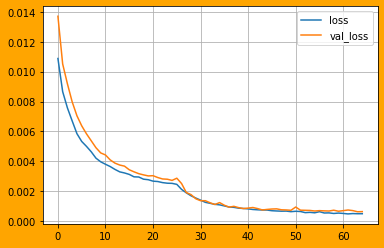

0.00050126644782722 0.0006417785189114511


In [30]:
fig = plt.figure()
fig.set_facecolor("orange")
plt.plot( loss[5:] )
plt.plot( val_loss[5:] )
plt.legend( labels=["loss","val_loss"] )
plt.savefig(f"{abspath}/loss.jpg")
plt.grid('on')
plt.show()
print(loss[-1], val_loss[-1])

In [95]:
# prediction

In [24]:
def regionMax(hm):
    width, height = hm.shape
    hmr = hm.reshape(1,width,height,1)
    kernel_initializer = tf.keras.initializers.constant( np.ones((1,11,11,1)) )
    bias_initializer = tf.keras.initializers.constant( np.zeros((1,)) )
    conv2Dfunc = tf.keras.layers.Conv2D(1, (11,11), padding="same", input_shape=(width,height,1), \
        kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)
    return conv2Dfunc(hmr).numpy().reshape(224,224)/121

def getKP(predhmr0, predhmr1, predhmr2): # input.shape=(224,224)
    upidx, mididx, downidx = predhmr0.argmax(), predhmr1.argmax(), predhmr2.argmax()
    upy, upx, midy, midx, downy, downx = upidx//224, upidx%224, mididx//224, mididx%224, downidx//224, downidx%224
    
    #print(upy, upx, midy, midx, downy, downx)
    
    isUpLeft, isMidLeft, isDownLeft = upx<112, midx<112, downx<112
    if int(isUpLeft)+int(isMidLeft)+int(isDownLeft) >= 2:
        upy, upx     = 0  + predhmr0[:125,:50].argmax()//50,       0      + predhmr0[:125,:50].argmax()%50
        midy, midx   = 60 + predhmr1[60:165,:60].argmax()//60,     0      + predhmr1[60:165,:60].argmax()%60
        downy, downx = 120+ predhmr2[120:,:50].argmax()//50,       0      + predhmr2[120:,:50].argmax()%50
    else:
        upy, upx     = 0  + predhmr0[:125,224-50:].argmax()//50,   224-50 + predhmr0[:125,224-50:].argmax()%50
        midy, midx   = 60 + predhmr1[60:165:,224-60:].argmax()//60,224-60 + predhmr1[60:165:,224-60:].argmax()%60
        downy, downx = 120+ predhmr2[120:,224-50:].argmax()//50,   224-50 + predhmr2[120:,224-50:].argmax()%50
    
    print(upy, upx, midy, midx, downy, downx, "|", int(predhm0.max()), int(predhm1.max()), int(predhm2.max()) )
    return upy, upx, midy, midx, downy, downx

20 195 124 188 218 210 | 29 211 255


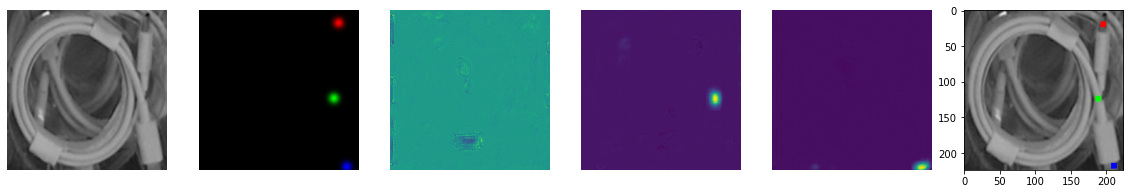

27 20 74 38 214 10 | 255 144 238


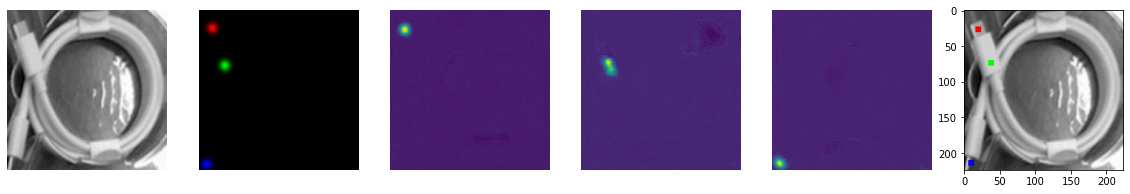

36 188 110 166 196 192 | 255 113 62


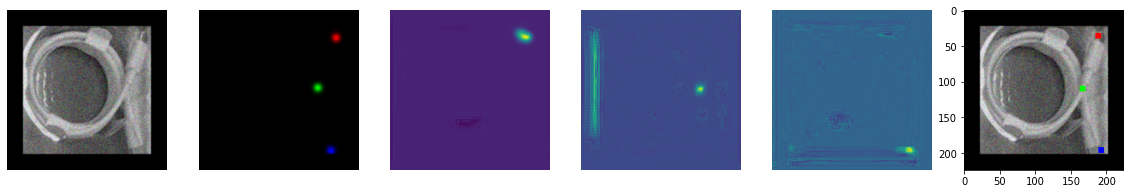

66 218 128 203 148 215 | 99 192 255


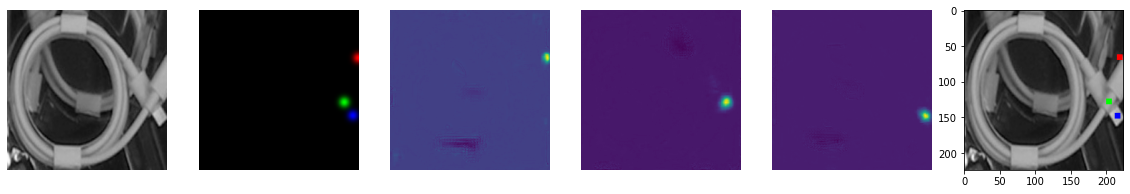

In [25]:
with open("train_dataset.pkl", "rb") as f:
    train_dataset = pickle.load(f)

for batch in train_dataset: # 
    (imgs, classes), hms = batch # 1-(4,224,224,3), (4,), 1-(4,224,224,3)
    for i in range(4):
        pred = model.predict( [imgs[i].reshape(1,224,224,3),np.array([[0]])] )[0,:,:,:3]      
        pred = ((pred-pred.min())/(pred.max()-pred.min())*255).astype(np.float32)
        predhm0, predhm1, predhm2 = pred[:,:,0], pred[:,:,1], pred[:,:,2]
        predhmr0, predhmr1, predhmr2 = regionMax(predhm0), regionMax(predhm1), regionMax(predhm2)
        upy, upx, midy, midx, downy, downx = getKP( predhmr0, predhmr1, predhmr2 )

        imgkp = imgs[i].copy()
        imgkp[upy-4:upy+4, upx-4:upx+4, 0] = 1
        imgkp[upy-4:upy+4, upx-4:upx+4, 1] = 0
        imgkp[upy-4:upy+4, upx-4:upx+4, 2] = 0
        imgkp[midy-4:midy+4, midx-4:midx+4, 0] = 0
        imgkp[midy-4:midy+4, midx-4:midx+4, 1] = 1
        imgkp[midy-4:midy+4, midx-4:midx+4, 2] = 0
        imgkp[downy-4:downy+4, downx-4:downx+4, 0] = 0
        imgkp[downy-4:downy+4, downx-4:downx+4, 1] = 0
        imgkp[downy-4:downy+4, downx-4:downx+4, 2] = 1
        
        plt.figure(figsize=(20,4))
        plt.subplot(1,6,1)
        plt.imshow( imgs[i] )
        plt.axis('off')
        plt.subplot(1,6,2)
        plt.imshow( hms[i] )
        plt.axis('off')
        
        plt.subplot(1,6,3)
        plt.imshow( predhm0 )
        plt.axis('off')
        plt.subplot(1,6,4)
        plt.imshow( predhm1 )
        plt.axis('off')
        plt.subplot(1,6,5)
        plt.imshow( predhm2  )
        plt.axis('off')
        plt.subplot(1,6,6)
        plt.imshow( imgkp  )
        #plt.axis('off')
        plt.show()
    break

In [1]:
with open("validation_dataset.pkl", "rb") as f:
    validation_dataset = pickle.load(f)

for batch in validation_dataset: # 
    (imgs, classes), hms = batch # 1-(4,224,224,3), (4,), 1-(4,224,224,3)
    for i in range(4):
        pred = model.predict( [imgs[i].reshape(1,224,224,3),np.array([[0]])] )[0,:,:,:3]        
        pred = ((pred-pred.min())/(pred.max()-pred.min())*255).astype(np.float32)
        predhm0, predhm1, predhm2 = pred[:,:,0], pred[:,:,1], pred[:,:,2]
        predhmr0, predhmr1, predhmr2 = regionMax(predhm0), regionMax(predhm1), regionMax(predhm2)
        upy, upx, midy, midx, downy, downx = getKP( predhmr0, predhmr1, predhmr2 )

        imgkp = imgs[i].copy()
        imgkp[upy-4:upy+4, upx-4:upx+4, 0] = 1
        imgkp[upy-4:upy+4, upx-4:upx+4, 1] = 0
        imgkp[upy-4:upy+4, upx-4:upx+4, 2] = 0
        imgkp[midy-4:midy+4, midx-4:midx+4, 0] = 0
        imgkp[midy-4:midy+4, midx-4:midx+4, 1] = 1
        imgkp[midy-4:midy+4, midx-4:midx+4, 2] = 0
        imgkp[downy-4:downy+4, downx-4:downx+4, 0] = 0
        imgkp[downy-4:downy+4, downx-4:downx+4, 1] = 0
        imgkp[downy-4:downy+4, downx-4:downx+4, 2] = 1
        
        plt.figure(figsize=(20,4))
        plt.subplot(1,6,1)
        plt.imshow( imgs[i] )
        plt.axis('off')
        plt.subplot(1,6,2)
        plt.imshow( hms[i] )
        plt.axis('off')
        
        plt.subplot(1,6,3)
        plt.imshow( predhm0 )
        plt.axis('off')
        plt.subplot(1,6,4)
        plt.imshow( predhm1 )
        plt.axis('off')
        plt.subplot(1,6,5)
        plt.imshow( predhm2  )
        plt.axis('off')
        plt.subplot(1,6,6)
        plt.imshow( imgkp  )
        #plt.axis('off')
        plt.show()
    #break

In [24]:
model.save(f"{abspath}/model_{str(datetime.datetime.now())[5:10]}.h5")

In [13]:
# testing

In [ ]:
#model = load_model("model_12-23.h5", custom_objects={"tf":tf, "myloss":(lambda y_true,y_pred:0)})

In [1]:
#testingList = ['20211217-083305_00011_color.jpg', '20211218-124434_00094_color.jpg', '20211218-141226_00032_color.jpg', '20211218-130227_00104_color.jpg', '20211218-175906_00127_color.jpg', '20211217-170411_00217_color.jpg', '20211218-110354_00077_color.jpg', '20211218-081456_00007_color.jpg', '20211218-165924_00101_color.jpg', '20211218-123929_00091_color.jpg']

In [3]:
# for folderName in map(lambda s:s.replace(".jpg",""), testingList):
#     folder = f"testing_data/inference_1221/{folderName}"
#     for imgName in filter(lambda s: "_.jpg" in s, sorted(os.listdir(folder))):
#         print(imgName)
#         img = cv2.imread(f"{folder}/{imgName}")/255.

#         pred = model.predict( [img.reshape(1,224,224,3),np.array([[0]])] )[0,:,:,:3]
#         pred = ((pred-pred.min())/(pred.max()-pred.min())*255).astype(np.uint8)
#         predhm0, predhm1, predhm2 = pred[:,:,0], pred[:,:,1], pred[:,:,2]
#         upy, upx, midy, midx, downy, downx = getKP( predhm0, predhm1, predhm2 )
#         print(upy, upx, midy, midx, downy, downx)

#         imgkp = img.copy()
#         imgkp[upy-4:upy+4, upx-4:upx+4, 0] = 1
#         imgkp[upy-4:upy+4, upx-4:upx+4, 1] = 0
#         imgkp[upy-4:upy+4, upx-4:upx+4, 2] = 0
#         imgkp[midy-4:midy+4, midx-4:midx+4, 0] = 0
#         imgkp[midy-4:midy+4, midx-4:midx+4, 1] = 1
#         imgkp[midy-4:midy+4, midx-4:midx+4, 2] = 0
#         imgkp[downy-4:downy+4, downx-4:downx+4, 0] = 0
#         imgkp[downy-4:downy+4, downx-4:downx+4, 1] = 0
#         imgkp[downy-4:downy+4, downx-4:downx+4, 2] = 1

#         plt.figure(figsize=(20,2))
#         plt.subplot(1,6,1)
#         plt.imshow( img )
#         plt.axis('off')
#         #plt.subplot(1,6,2)
#         #plt.imshow( hms[i] )
#         #plt.axis('off')

#         plt.subplot(1,6,3)
#         plt.imshow( predhm0 )
#         #plt.axis('off')
#         plt.subplot(1,6,4)
#         plt.imshow( predhm1 )
#         #plt.axis('off')
#         plt.subplot(1,6,5)
#         plt.imshow( predhm2  )
#         #plt.axis('off')
#         plt.subplot(1,6,6)
#         plt.imshow( imgkp  )
#         #plt.axis('off')
#         plt.show()